# Global birth rate analysis

Birth rate by country and the global birth rate will be analyzed under the impacts of the following factors: 
- Economy: GDP per Capita, inflation
- Social: Happiness index, Social support score, life expectancy, freedom to make life choices, generosity,perception of corruption
- Jobs: Unemployment rate

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

## Data Import & Data Preparation

In [44]:
# Data import
df_birth_rate = pd.read_csv("birth_rate.csv")
df_gdp = pd.read_csv("GDP.csv")
df_happiness_index = pd.read_excel("DataForFigure2.1WHR2023.xls")
df_unemployment_rate = pd.read_csv('unemployment_rate.csv')
df_inflation_rate = pd.read_excel('inflation-data.xlsx',sheet_name='hcpi_a')


In [45]:
# Drop duplicates & rename columns
df_birth_rate = df_birth_rate.rename({'country': 'Country'}, axis='columns')
df_gdp = df_gdp.drop_duplicates(subset='country', keep='first')
df_gdp = df_gdp.rename({'country': 'Country'}, axis='columns')
df_happiness_index = df_happiness_index.rename({'Country name': 'Country'},
                                               axis='columns')
df_unemployment_rate = df_unemployment_rate.rename({'country': 'Country'},
                                                    axis='columns')
df_inflation_rate = df_inflation_rate.rename({2022:'inflation'}, axis='columns')


In [46]:
# Preliminary variable selection
df_birth_rate = df_birth_rate[['birthRate', 'Country']]
df_gdp = df_gdp[['Country', 'gdpPerCapita']]
df_happiness_index = df_happiness_index[['Country', 'Ladder score', 'Social support', 
                                         'Healthy life expectancy',
                                         'Freedom to make life choices', 
                                         'Generosity', 'Perceptions of corruption']]
df_unemployment_rate = df_unemployment_rate[['Country', 'rateWb']]
df_inflation_rate = df_inflation_rate[['Country', 'inflation']]


In [47]:
# Main data frame preparation
df_final = df_birth_rate.merge(df_gdp,
                                on='Country').merge(df_happiness_index,
                                                     on='Country').merge(df_unemployment_rate, on='Country').merge(df_inflation_rate, on='Country')

df_final.columns

Index(['birthRate', 'Country', 'gdpPerCapita', 'Ladder score',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'rateWb', 'inflation'],
      dtype='object')

In [48]:
df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']] = df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]*100
df_final.loc[8, 'inflation'] = 3.9

In [49]:
# Data partition
df_predictors = df_final[['gdpPerCapita', 'Ladder score', 'Social support', 
                          'Healthy life expectancy', 'Freedom to make life choices',
                          'Generosity', 'Perceptions of corruption', 'rateWb',
                            'inflation']]
df_target = df_final['birthRate']

x_train, x_test, y_train, y_test = train_test_split(df_predictors,df_target,test_size=0.25)


## Data Exploration

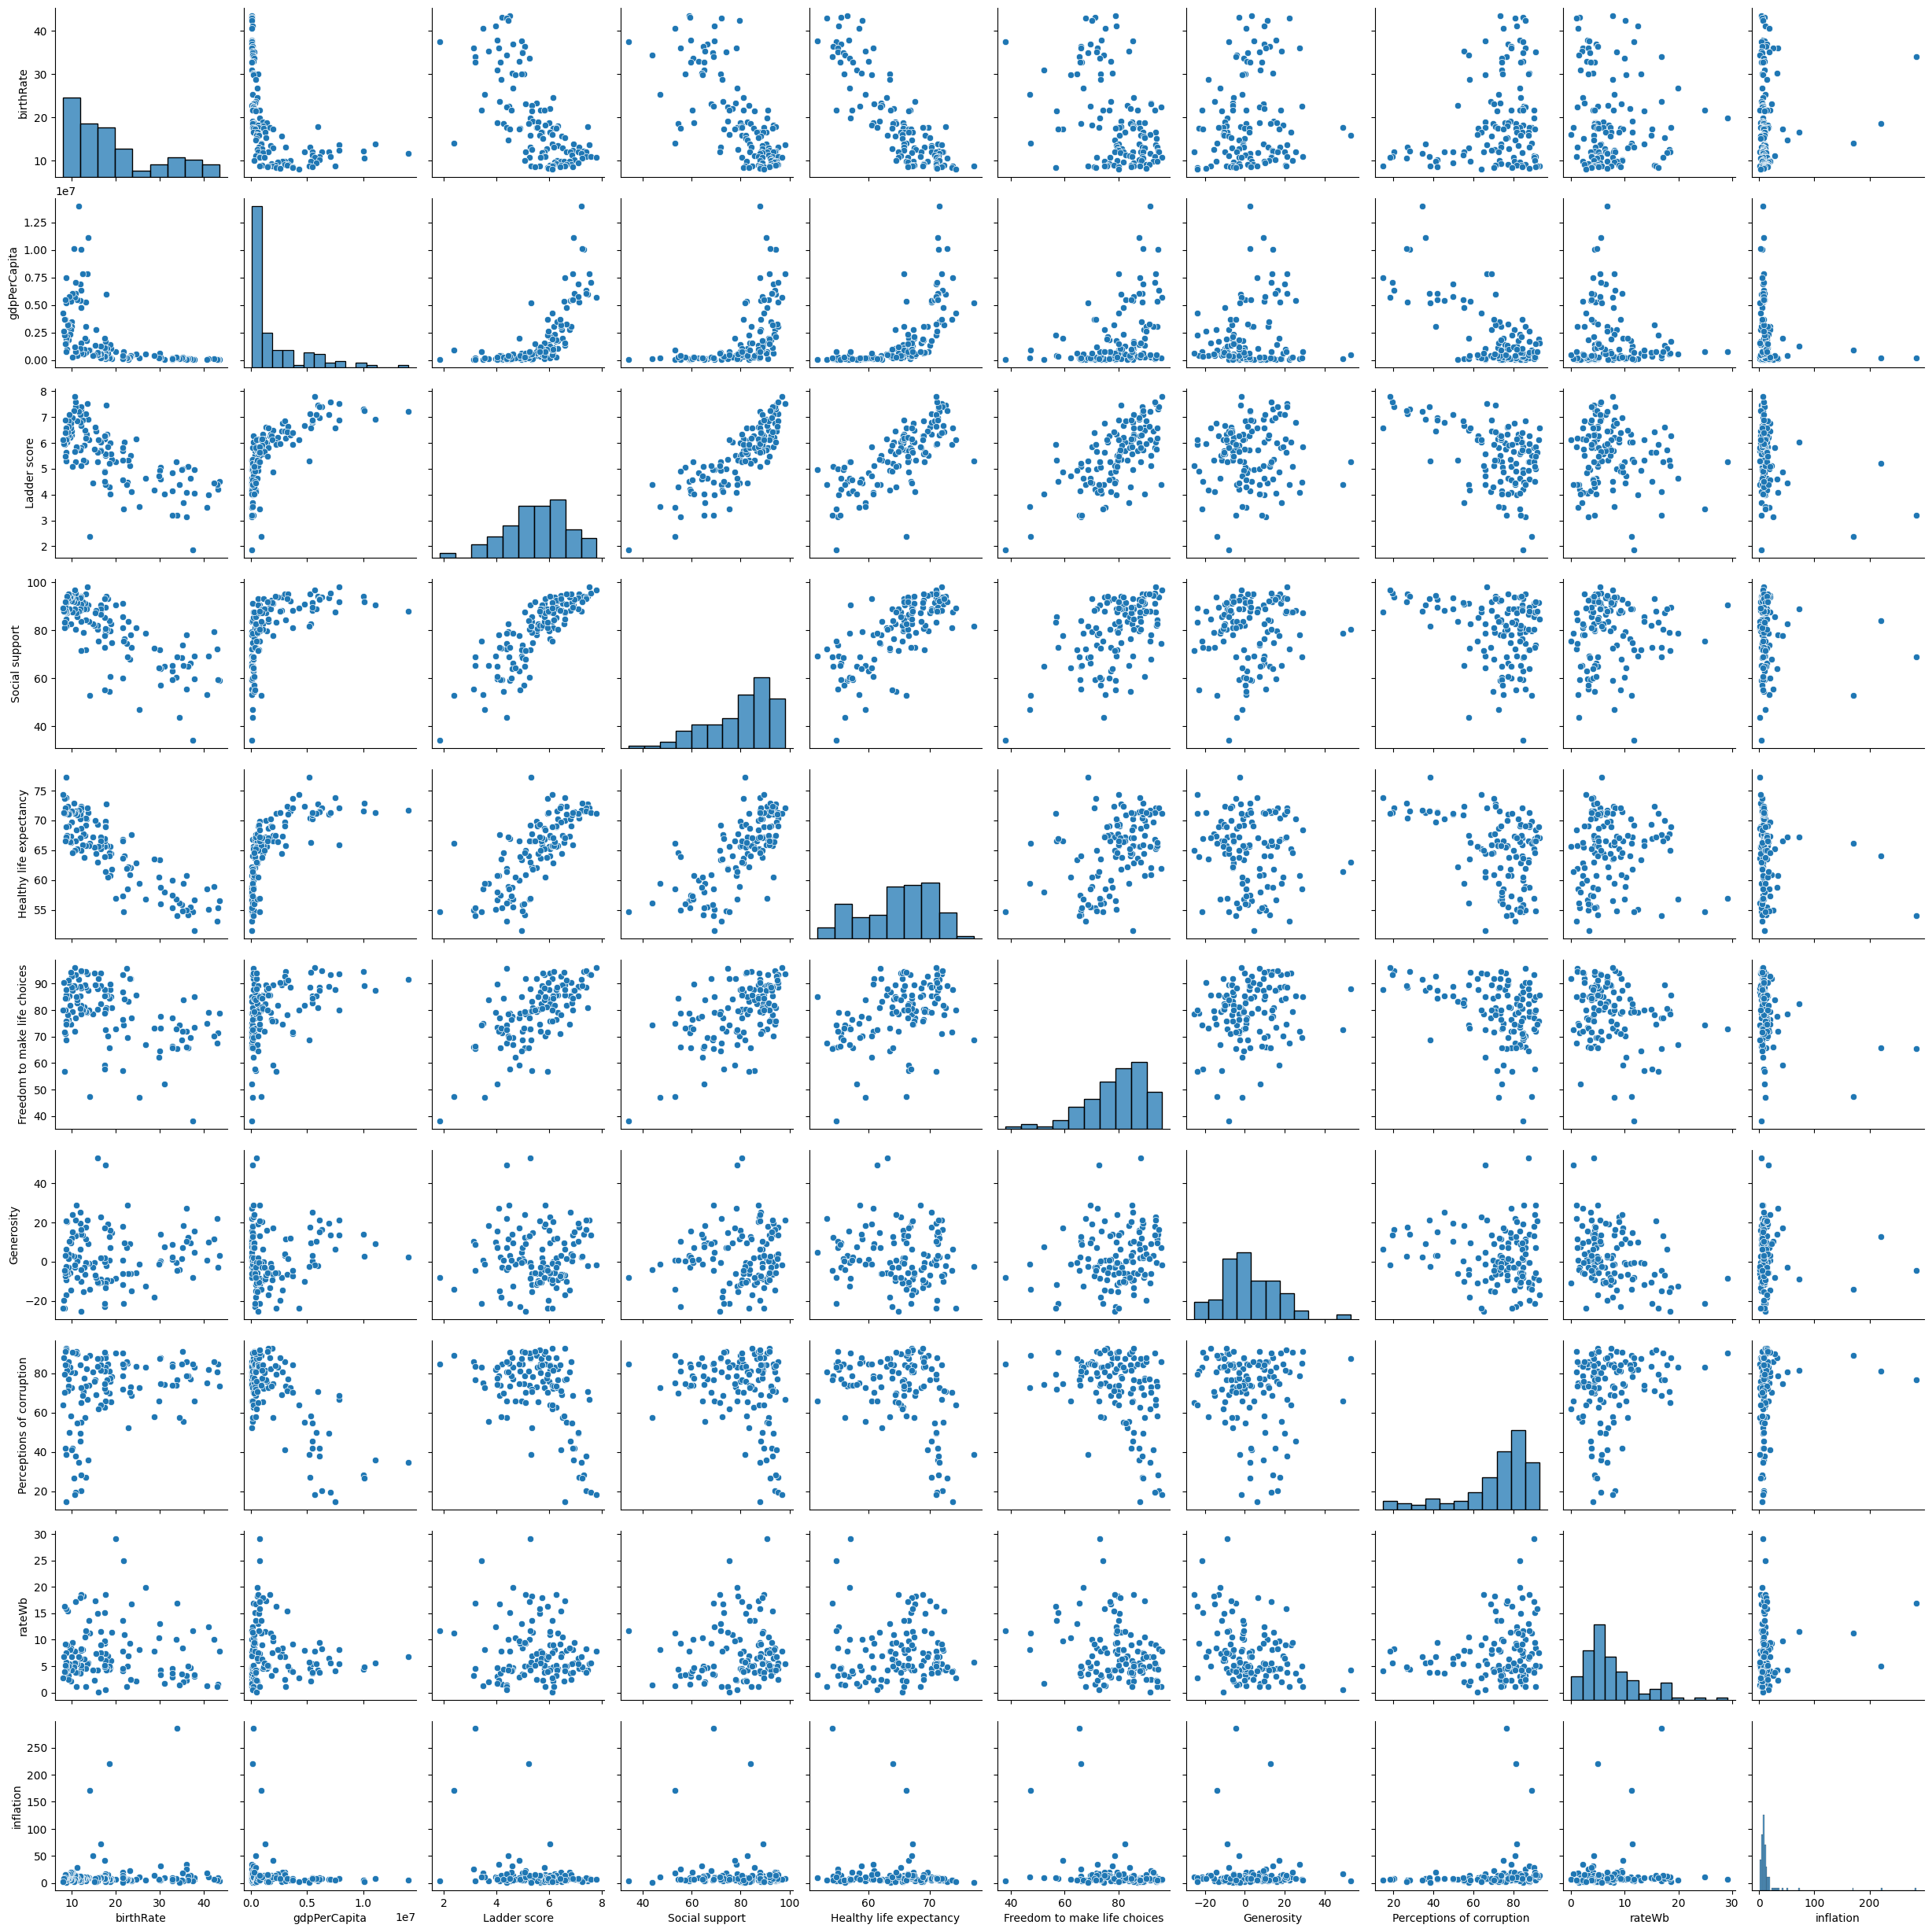

In [50]:
sns.pairplot(df_final)

## Model Fit & Model result

It is noted that the model produced the following results: Holding other predictors constant:
- GDP coefficient is minimal, having minimal impacts on birth rates
- An increase in 1 happiness index, increase birth rate by 0.32 point


In [51]:
model = linear_model.LinearRegression()

In [52]:
model.fit(x_train,y_train)

LinearRegression()

In [53]:
# birth_rate fitted and birth_rate prediction
y_fitted = model.predict(x_train)
y_predict = model.predict(x_test)

In [54]:
# residuals from train & test
residuals_train = y_train - y_fitted
residuals_test = y_test - y_predict

In [55]:
# Coefficients
coef_gdp = model.coef_[0]
coef_happiness_index = model.coef_[1]
coef_social_support = model.coef_[2]
coef_life_expectancy = model.coef_[3]
coef_freedom = model.coef_[4]
coef_generosity = model.coef_[5]
coef_corruption = model.coef_[6]
coef_unemployment = model.coef_[7]
coef_inflation = model.coef_[8]
intercept = model.intercept_
model.coef_

array([-3.09199593e-08, -5.71263749e-01, -1.00132292e-01, -1.24145663e+00,
       -5.35772376e-02,  3.57750325e-02, -5.59891870e-02, -8.14555204e-02,
       -2.70692394e-02])

In [56]:
print('model = %f + %f GDP %f Happiness index  %f Social support %f life expectancy  %f freedom  %f generosity  %f corruption  %f Unemployment %f Inflation' % (intercept, coef_gdp, coef_happiness_index, coef_social_support, coef_life_expectancy, coef_freedom, coef_generosity, coef_corruption, coef_unemployment, coef_inflation))

model = 120.023697 + -0.000000 GDP -0.571264 Happiness index  -0.100132 Social support -1.241457 life expectancy  -0.053577 freedom  0.035775 generosity  -0.055989 corruption  -0.081456 Unemployment -0.027069 Inflation


In [57]:
stats_model = sm.OLS(y_train, x_train).fit()

## Model & Predictors Evaluation

In [58]:
def model_significance(y_train_set, y_pred, p):
    y_mean = np.mean(y_train_set)
    tss = ((y_train_set - y_mean)**2).sum()
    rss = ((y_train_set - y_pred)**2).sum()
    n = len(y_train_set)
    f_test = (tss-rss)/(rss/(n-p-1))
    print(f_test)
    if f_test > 1:
        print("Reject Ho. At least one of the model coefficients is significant.")
    if f_test <=1: 
        print("Accept Ho. No coefficients are useful.")


def coefficient_testing(coeff, residuals, trainset,p):
    """Perform Hypothesis testing to determine if Coefficient in regression is significant"""
    # Obtain the residual standard deviation
    residual_variance = np.var(residuals)
    x_mean = np.mean(trainset)
    x_squared = ((trainset - x_mean)**2).sum()
    coeff_var = residual_variance/ x_squared
    coeff_std = np.sqrt(coeff_var)
    print("coeff_var, std:",coeff_var, coeff_std)
    # Obtain t test
    print("Hypothesis: Ho: B1 = 0, Ha: B1 !=0")
    t_value = coeff/coeff_std
    print("t_value:", t_value)
    degree_of_freedom = len(trainset) - p -1
    p_value = stats.t.sf(abs(t_value), degree_of_freedom)*2
    print ("p_value: %.24f" % p_value)
    # Conclusion:
    if p_value < 0.05:
        print('Reject Ho. The coefficient is significant, and has a relationship with the respond variable')
    if p_value > 0.05: 
        print('Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable')
    return None


def residual_zero_mean(residuals,p):
    n = len(residuals)
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    t_test = (residual_mean)/(residual_std/np.sqrt(n))
    p_value = stats.t.sf(t_test, n - p - 1)
    if p_value > 0.05:
        print("As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.")
    elif p_value <= 0.05: 
        print("As p_value is smaller than 0.95, there is sufficient evidence to reject Ho. Thus zero mean assumption is not appropriate.")

def tss_rss(y_train, y_pred):
    y_mean = np.mean(y_train)
    tss = ((y_train - y_mean)**2).sum()
    rss = ((y_train - y_pred)**2).sum()
    n = len(y_train)
    return tss, rss

def autocorrelation(residuals):
    print("Ho: There is no correlation among residuals")
    print("Ha: There is correlation between residuals")
    test = durbin_watson(residuals)
    print(test)
    if test>= 0 and test <= 1.5: 
        print("Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.")
    elif test > 1.5 and test <= 2.5:
        print("Do not reject Ho. There is no correlation among residuals.")
    elif test > 2.5:
        print("Reject Ho. There is sufficient evidence indicating a negative correlation in the residuals")
        
def normal_distribution(residuals):
    print("Ho: The residuals are normally distributed.")
    print("Ha: The residuals are not normally distributed.")
    k, p_value = stats.normaltest(residuals)
    print(p_value)
    if p_value < 0.05:
        print("Reject Ho. The residuals are not normally distributed.")
    elif p_value > 0.05:
        print("Do not have sufficient evidence to reject Ho. The residuals are normally distributed.")

### Model Evaluation

In [59]:
# Model evaluation - F test
model_significance(y_train, y_fitted, 8)

265.22478428861416
Reject Ho. At least one of the model coefficients is significant.


### Coefficient evaluation


In [60]:
# GDP coefficient
coefficient_testing(coef_gdp, residuals_train, x_train['gdpPerCapita'],8)

coeff_var, std: 3.0538220455811247e-14 1.747518825529821e-07
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.17693634443628836
p_value: 0.859964987429408411756526
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [61]:
# Happiness index
coefficient_testing(coef_happiness_index, residuals_train, x_train['Ladder score'], 8)

coeff_var, std: 0.17564343860160447 0.4190983638736907
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -1.3630779754281583
p_value: 0.176335523186342379986513
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [62]:
# Social support
coefficient_testing(coef_social_support, residuals_train, x_train['Social support'],8)

coeff_var, std: 0.0013441181616115458 0.036662217085325674
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.731212124438228
p_value: 0.007623422353291877014148
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [63]:
# Healthy life expectancy
coefficient_testing(coef_life_expectancy, residuals_train, x_train['Healthy life expectancy'], 8)

coeff_var, std: 0.00797863208269418 0.08932318894158549
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -13.898480866436442
p_value: 0.000000000000000000000006
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [64]:
# Freedom to make life choices
coefficient_testing(coef_freedom, residuals_train, x_train['Freedom to make life choices'], 8)


coeff_var, std: 0.001954854222625525 0.04421373341650222
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -1.211778183685608
p_value: 0.228841038314955669275008
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [65]:
# Generosity
coefficient_testing(coef_generosity, residuals_train, x_train['Generosity'], 8)

coeff_var, std: 0.0013003200250604856 0.036059950430643764
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.9920987705579191
p_value: 0.323869479476136756801452
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [66]:
# Perceptions of corruption
coefficient_testing(coef_corruption, residuals_train, x_train['Perceptions of corruption'], 8)

coeff_var, std: 0.0006906599179207605 0.02628040939408594
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.130453378949523
p_value: 0.035924451355977465860647
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [67]:
# Unemployment rate: rateWb
coefficient_testing(coef_unemployment, residuals_train, x_train['rateWb'], 8)

coeff_var, std: 0.008619878818562368 0.09284330249706958
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.8773440649549179
p_value: 0.382688728533843502965794
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [68]:
# Inflation rate
coefficient_testing(coef_inflation, residuals_train, x_train['inflation'],8)

coeff_var, std: 0.00029920763981767325 0.017297619484127672
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -1.564911254419155
p_value: 0.121192866100483562230572
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


## Accuracy Evaluation

#### Train set

In [69]:
tss_train, rss_train = tss_rss(y_train, y_fitted)

In [70]:
n_train = len(y_train)
rse_train = np.sqrt(rss_train/(n_train-8-1))
r_squared_train = (tss_train-rss_train)/tss_train

In [71]:
print("RSE:", rse_train)
print("R-squared:", r_squared_train)

RSE: 5.067577624098225
R-squared: 0.75086685896849


#### Test set

In [72]:
tss_test, rss_test = tss_rss(y_test, y_predict)
n_test = len(y_test)
rse_test = np.sqrt(rss_test/(n_test - 8-1))
r_squared_test = (tss_test-rss_test)/tss_test

In [73]:
print("RSE:", rse_test)
print("R-squared:", r_squared_test)

RSE: 4.796062217143535
R-squared: 0.8539182520450062


## Residuals Evaluation

Residuals will be assessed for the following factors: 
- Mean of zero
- Normally distributed
- Constant variance
- Autocorrelation check

In [74]:
# Test residuals mean of zero
residual_zero_mean(residuals_test, 8)

As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.


Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.9637754544645414
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.


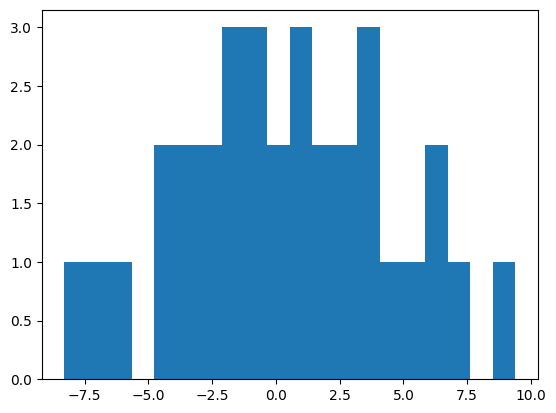

In [75]:
# Test for Normal distribution
plt.hist(residuals_test, bins=20)

normal_distribution(residuals_test)

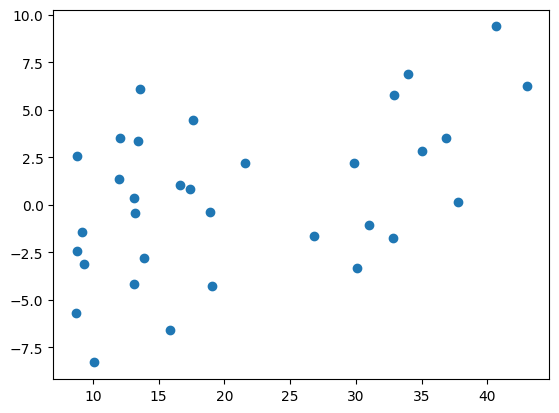

In [76]:
# Test for constant variance
plt.scatter(y_test, residuals_test)

In [77]:
# Autocorrelation check
autocorrelation(residuals_test)



Ho: There is no correlation among residuals
Ha: There is correlation between residuals
2.2345536422182564
Do not reject Ho. There is no correlation among residuals.


## Model Fit & Evaluation - Interaction terms added

In [78]:
poly = PolynomialFeatures(interaction_only=True)
x_train_interact = poly.fit_transform(x_train)
x_test_interact = poly.fit_transform(x_test)

In [79]:
# Rename columns
df_interact_train = pd.DataFrame(x_train_interact, columns=poly.get_feature_names_out())
df_interact_test = pd.DataFrame(x_test_interact, columns=poly.get_feature_names_out())

In [95]:
selection = SelectKBest(score_func=f_regression, k=4)
results = selection.fit(df_interact_train, y_train)
names = pd.DataFrame(df_interact_train.columns)

print (results.pvalues_)

results_df=pd.DataFrame(results.pvalues_)
results_score = pd.DataFrame(results.scores_)

#Concat and name columns
scored=pd.concat([names,results_df, results_score], axis=1)
scored.columns = ["Feature", "p-values", "scores"]
scored.sort_values(by=['p-values']).head(20)

[1.00000000e+00 1.61839575e-07 2.21638077e-14 5.53638263e-16
 1.76261854e-27 2.27246354e-05 1.00017904e-01 4.06093318e-03
 5.89095515e-01 8.38085144e-01 7.31540550e-07 1.85033015e-07
 2.00686718e-07 4.93604365e-07 2.02444894e-01 2.60789157e-10
 2.23060955e-07 3.11060273e-06 3.21330503e-17 5.81002359e-19
 1.88293952e-12 2.45096808e-01 3.89361489e-02 1.77482685e-02
 5.01237065e-01 1.00869494e-22 1.13334235e-13 1.75400220e-01
 1.65175152e-01 6.99677045e-02 5.87103116e-01 1.57550362e-13
 1.52042907e-01 8.49101859e-01 1.48819126e-01 6.50653685e-01
 1.57509991e-01 4.39025895e-01 1.97066617e-01 7.17856588e-01
 2.12633244e-02 2.40333414e-01 2.07645374e-01 8.12255309e-01
 9.66656789e-01 5.32222739e-01]


,Feature,p-values,scores
4,Healthy life expectancy,1.762619e-27,235.800191
25,Social support Healthy life expectancy,1.008695e-22,167.961661
19,Ladder score Healthy life expectancy,5.810024e-19,124.407826
18,Ladder score Social support,3.213305e-17,106.774575
3,Social support,5.536383e-16,95.145306
2,Ladder score,2.216381e-14,81.081978
26,Social support Freedom to make life choices,1.133342e-13,75.206118
31,Healthy life expectancy Freedom to make life c...,1.575504e-13,74.044678
20,Ladder score Freedom to make life choices,1.882940e-12,65.555615
15,gdpPerCapita Perceptions of corruption,2.607892e-10,49.969666


Variable selected: Aiming at 15 observations per variable:
- Healthy life expectancy
- Social support Healthy life expectancy
- Ladder score Healthy life expectancy
- Ladder score Social support
- Ladder score
- Social support 

In [100]:
scored_sorted = scored.sort_values(by=['p-values'])
columns = list(scored_sorted['Feature'][0:6])

In [101]:
df_interact_train = df_interact_train[columns]
df_interact_test = df_interact_test[columns]

In [103]:
model_int = linear_model.LinearRegression()
model_int.fit(df_interact_train, y_train)

LinearRegression()

In [104]:
# y fitted and y predict
y_fitted_int = model_int.predict(df_interact_train)
y_predict_int = model_int.predict(df_interact_test)

In [106]:
# Residuals train and test
residuals_interact_train = y_train - y_fitted_int
residuals_interact_test = y_test - y_predict_int

In [109]:
# coefficient
df_interact_train.columns
coef_int_life_exp = model_int.coef_[0]
coef_int_social_life_exp = model_int.coef_[1]
coef_int_happiness_life_exp = model_int.coef_[2]
coef_int_happiness_social = model_int.coef_[3]
coef_int_social = model_int.coef_[4]
coef_int_happiness = model_int.coef_[5]

### Model & coefficient evaluation

In [110]:
# F_test
model_significance(y_train, y_fitted_int, 6)

298.4927148118421
Reject Ho. At least one of the model coefficients is significant.


In [112]:
coefficient_testing(coef_int_life_exp, residuals_interact_train, df_interact_train['Healthy life expectancy'],6)

coeff_var, std: 0.007419191239249855 0.08613472725474816
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -49.25351477326565
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [113]:
coefficient_testing(coef_int_social_life_exp, residuals_interact_train, df_interact_train['Social support Healthy life expectancy'],6)

coeff_var, std: 1.585890046194311e-07 0.00039823235004131835
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 58.79939194998313
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [114]:
coefficient_testing(coef_int_happiness_life_exp, residuals_interact_train, df_interact_train['Ladder score Healthy life expectancy'],6)

coeff_var, std: 2.241419298315659e-05 0.004734362996555776
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 50.271501796950915
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [115]:
coefficient_testing(coef_int_happiness_social, residuals_interact_train, df_interact_train['Ladder score Healthy life expectancy'],6)

coeff_var, std: 2.241419298315659e-05 0.004734362996555776
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -23.378706969277644
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [116]:
coefficient_testing(coef_int_social, residuals_interact_train, df_interact_train['Social support'],6)

coeff_var, std: 0.001249872106620264 0.03535353032753962
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -29.029987849871237
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [117]:
coefficient_testing(coef_int_happiness, residuals_interact_train, df_interact_train['Ladder score'],6)

coeff_var, std: 0.16332777942365143 0.40413831719307614
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -18.71123261139729
p_value: 0.000000000000000000000000
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [119]:
tss_int, rss_int = tss_rss(y_train, y_fitted_int)
n_int = len(y_train)

In [121]:
rse_int = np.sqrt(rss_int/(n_int - 6 -1))
r_squared_int = (tss_int - rss_int)/tss_int
print(rse_int, r_squared_int)

4.832084881258517 0.7683354241440807


In [125]:
tss_int_test, rss_int_test = tss_rss(y_test, y_predict_int)
n_int_test = len(y_test)
rse_int_test = np.sqrt(rss_int_test/(n_int_test - 6-1))
r_squared_int_test = (tss_int_test - rss_int_test)/tss_int_test
print(rse_int_test, r_squared_int_test)

4.4717435265948655 0.8624241450810985


### Residuals evaluation

Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.07266528843865182
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.
Ho: The residuals are normally distributed.
Ha: The residuals are not normally distributed.
0.9466541772036051
Do not have sufficient evidence to reject Ho. The residuals are normally distributed.


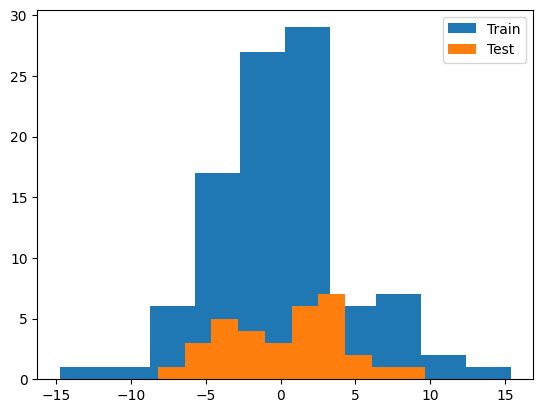

In [131]:
# Histogram
plt.hist(residuals_interact_train)
plt.hist(residuals_interact_test)
plt.legend(['Train', 'Test'])
normal_distribution(residuals_interact_train)
normal_distribution(residuals_interact_test)

In [129]:
# Zero mean
residual_zero_mean(residuals_interact_train,6)
residual_zero_mean(residuals_interact_test,6)

As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.
As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.


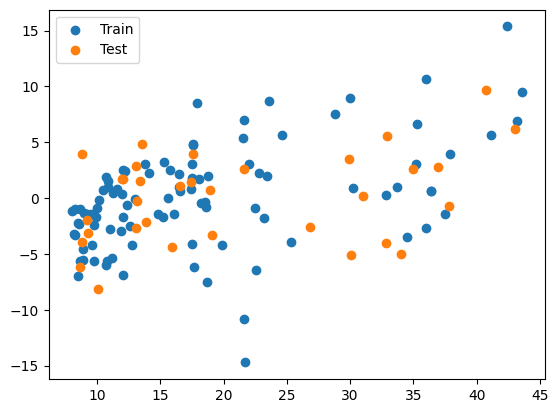

In [130]:
# Constant variance
plt.scatter(y_train,residuals_interact_train)
plt.scatter(y_test, residuals_interact_test)
plt.legend(['Train', 'Test'])


In [132]:
# Autocorrelation
autocorrelation(residuals_interact_train)
autocorrelation(residuals_interact_test)

Ho: There is no correlation among residuals
Ha: There is correlation between residuals
1.956625954468279
Do not reject Ho. There is no correlation among residuals.
Ho: There is no correlation among residuals
Ha: There is correlation between residuals
2.4575926992323383
Do not reject Ho. There is no correlation among residuals.
